In [1]:
import json
import os
import re
from datetime import datetime, timedelta
from urllib.parse import urlparse
import time
import yaml

import bs4
from bs4 import BeautifulSoup
import requests

import dotenv

import IPython
from IPython.display import HTML, Markdown, display

from atproto import Client

import PIL
from PIL import Image


In [2]:
print(f"requests        {requests.__version__}")
print(f"BeautifulSoup   {bs4.__version__}")


requests        2.32.3
BeautifulSoup   4.13.3


In [3]:
dotenv.load_dotenv()


True

# Load posts from BlueSky and format for Substack or a blog post
for now I share the interesting stuff on bluesky and then use this code to grab latest BlueSky 'tweets' and format a [Substack post](https://skynetandchill.com)


In [4]:
client = Client(base_url='https://bsky.social')
client.login(os.environ['BSKY_USERNAME'], os.environ['BSKY_SECRET'])

mydid = {"did":"did:plc:qomkdnxrqw3gkbytdxea5z65"}

data = client.get_author_feed(
    actor=mydid['did'],
    filter='posts_and_author_threads',
    limit=50,
)


In [5]:
def remove_urls(text):
    # Regular expression to match URLs
    url_pattern = r'https?://\S+|www\.\S+'
    # Substitute found URLs with an empty string
    clean_text = re.sub(url_pattern, '', text)
    return clean_text


In [6]:
def rawfetchurl(url, timeout=60):
    """get url using requests with specified timeout. return response object, status, content-type"""
    try:
        response = requests.get(url, timeout=timeout)
    except httplib.BadStatusLine:
        log("Bad response (?) fetching url %s " % url)
        response = None
    except requests.Timeout:
        log("Timeout fetching url %s " % url)
        response = None
    except requests.ConnectionError as e:
        log("Connection error (%s) fetching url %s " % (str(e), url))
        response = None
    except requests.TooManyRedirects:
        log("Too many redirects fetching url %s " % url)
        response = None
    except requests.exceptions.MissingSchema:
        log("Missing schema url %s " % url)
        response = None
    except requests.exceptions.InvalidSchema:
        log("Invalid schema url %s " % url)
        response = None
    except requests.exceptions.InvalidURL as e:
        log("Invalid url %s, %s" % (url, str(e)))
        response = None
    except ValueError as e:
        # don't log url because possibly malformed url
        log("ValueError, url ?: ? ")
        response = None
    except httplib.IncompleteRead as e:
        log("IncompleteRead, url %s: %s " % (url, str(e)))
        response = None
    except urllib3.exceptions.SSLError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ContentDecodingError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ChunkedEncodingError as e:
        log("ChunkedEncodingError, url %s: %s " % (url, str(e)))
        response = None
    except UnicodeEncodeError as e:
        log("UnicodeEncodeError, url %s: %s " % (url, str(e)))
        response = None
    except OpenSSL.SSL.SysCallError as e:
        log("OpenSSL.SSL.SysCallError, url %s: %s " % (url, str(e)))
        response = -1
    except OpenSSL.SSL.ZeroReturnError as e:
        log("OpenSSL.SSL.ZeroReturnError, url %s: %s " % (url, str(e)))
        response = -1

    # except requests.packages.urllib3.exceptions.DecodeError as e:
    #     utilLog("DecodeError, url %s: %s " % (url, str(e)))
    #     response = None

    return response



In [7]:
def resize_and_crop(input_image_path, output_image_path, desired_height=240):
    # Load the image
    with Image.open(input_image_path) as img:
        img = img.convert('RGB')

        # Calculate the new width maintaining the aspect ratio
        aspect_ratio = img.width / img.height
        new_width = int(desired_height * aspect_ratio)

        # Resize the image
        resized_img = img.resize((new_width, desired_height))

        # Save the resized image
        resized_img.save(output_image_path)


In [8]:
# attempt to remove traiing inline URLs

def truncate_last_occurrence(text: str) -> str:
    # Find trailing occurrence of a space followed by any sequence of characters followed by 3 periods
    pattern = r'\s+\S+\.{3}$'
    return re.sub(pattern, '', text)

# Example text for testing

example_text = """Elon Musk says we'll run out of power capacity to run all the AI chips in 2025
newatlas.com/technology/e..."""

# Truncate the last occurrence
print(truncate_last_occurrence(example_text))


Elon Musk says we'll run out of power capacity to run all the AI chips in 2025


In [9]:
def get_og_tags(url):
    """get a dict of Open Graph og: tags such as title in the HEAD of a URL"""
    retdict = {}
    try:
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, "html.parser")
            head = soup.head
            if head:
                og_tags = head.find_all(
                    property=lambda prop: prop and prop.startswith("og:")
                )
                for tag in og_tags:
                    if "content" in tag.attrs:
                        retdict[tag["property"]] = tag["content"]

                page_title = ""
                title_tag = soup.find("title")
                if title_tag:
                    page_title = title_tag.text
                    if page_title:
                        retdict["title"] = page_title
        return retdict
    except requests.RequestException as e:
        log(f"Error fetching {url}: {e}")
    return retdict


url = "https://druce.ai"
get_og_tags(url)

{'og:site_name': 'Druce.ai',
 'og:title': 'Druce.ai',
 'og:type': 'website',
 'og:description': "Druce's Blog on Machine Learning, Tech, Markets and Economics",
 'og:url': 'https://druce.ai/',
 'title': 'Druce.ai'}

In [10]:
def delete_files(outputdir):

    # Iterate over all files in the directory
    for filename in os.listdir(outputdir):
        if filename.startswith('.'):
            continue
        file_path = os.path.join(outputdir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)  # Remove the file
            elif os.path.isdir(file_path):
                # If you want to remove subdirectories as well, use os.rmdir() here
                pass
        except Exception as e:
            log(f'Failed to delete {file_path}. Reason: {e}')
            


 x <br /> 



 <br /> 


[Training on bad code drives GPT-4o mad](https://www.theregister.com/2025/02/27/llm_emergent_misalignment_study/)

___

[Vibecoding with AI](https://www.nytimes.com/2025/02/27/technology/personaltech/vibecoding-ai-software-programming.html)

___

[The ‘Spy Sheikh’ Taking the AI World by Storm](https://www.wsj.com/tech/ai/abu-dhabi-spy-sheikh-ai-c4a9d48c)

___

[Salesforce won't hire engineers in 2025 due to AI tools](https://www.theregister.com/2025/02/27/salesforce_misses_revenue_guidance/)

___

[Teaching a robot to play the piano](https://kzakka.com/robopianist/#demo)

___

[Humanoid Robots Finally Get Real Jobs](https://www.wsj.com/tech/ai/humanoid-robot-workers-ai-brain-08027439?st=UR82Ge&reflink=desktopwebshare_permalink)

___

Huang also addresses DeepSeek, custom silicon threats

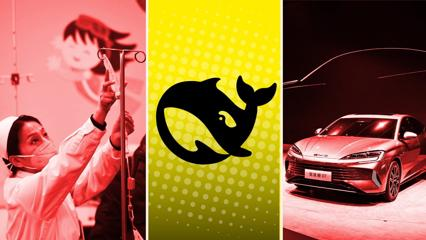

[China deploys DeepSeek everywhere as its new AI national champion](https://www.ft.com/content/5684fb1f-1a84-4542-8fe9-2fcae9653f87)

___

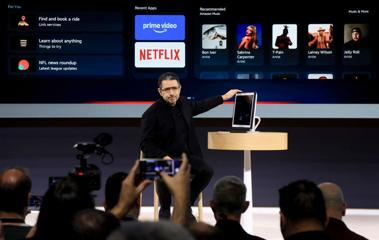

[Alexa+ can chat like an LLM, browse the web, and perform agentic tasks.](https://arstechnica.com/gadgets/2025/02/amazons-subscription-based-alexa-looks-highly-capable-and-questionable/) - Ars Technica

___

[Nvidia improves inference performance, thinks Blackwell should do both training and inference, as opposed to using specialized inference chips.](https://www.wsj.com/tech/ai/how-nvidia-adapted-its-chips-to-stay-ahead-of-an-ai-industry-shift-044edaad?st=fgHooc&reflink=desktopwebshare_permalink)

___

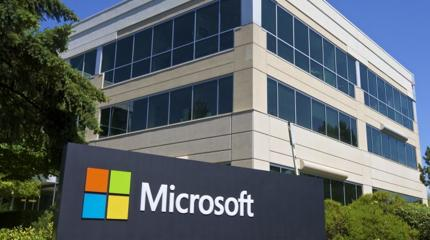

[Microsoft updates Phi small language models with a 3.8b-parameter text model and a 5.6b-parameter multimodal model](https://siliconangle.com/2025/02/26/microsoft-releases-new-phi-models-optimized-multimodal-processing-efficiency/) - SiliconANGLE

___

The product teams over at the Post have put together a nifty feature that summarises comments. 

Here's the one on the story about the owner's latest move... They're not loving it

name 'httplib' is not defined


[AI Agents Are Changing How People Shop. Here’s What That Means for Brands.](https://hbr.org/2025/02/ai-agents-are-changing-how-people-shop-heres-what-that-means-for-brands) - Harvard Business Review

___

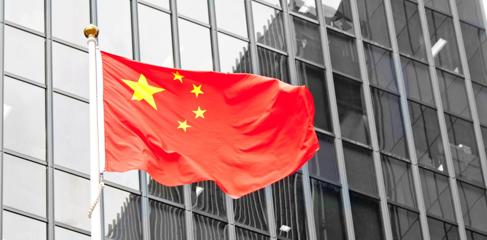

[DeepSeek is now a global force. But it’s just one player in China’s booming AI industry](https://theconversation.com/deepseek-is-now-a-global-force-but-its-just-one-player-in-chinas-booming-ai-industry-250494) - The Conversation

___

[Trump posts offensive, demented AI 'Trump Gaza' video](https://www.israelhayom.com/2025/02/26/trump-shares-gaza-ai-video-showing-him-netanyahu-sunbathing/)

___

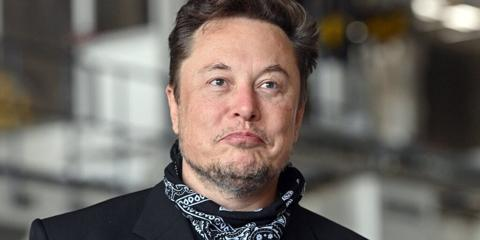

[Man claims to build in-browser flightsim with Cursor](https://decrypt.co/307892/ai-gaming-massive-elon-musk-shares-game) - Decrypt

___

[Nvidia reports strong quarter, stock flat](https://www.cnbc.com/2025/02/26/nvidia-nvda-earnings-report-q4-2025.html)

___

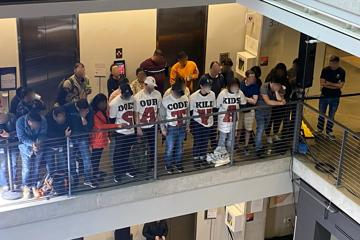

['Does Our Code Kill Kids?': Microsoft employees ejected from  town hall over AI protest](https://gizmodo.com/does-our-code-kill-kids-microsoft-employees-protest-selling-ai-to-israel-2000568642) - Gizmodo

___

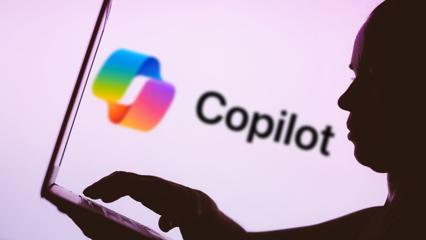

[Thousands of exposed GitHub repositories, now private, can still be accessed through Copilot](https://techcrunch.com/2025/02/26/thousands-of-exposed-github-repositories-now-private-can-still-be-accessed-through-copilot/) - TechCrunch

___

[Leaked chats analyzed with AI discuss \\$750k ransomware offer](https://www.theregister.com/2025/02/25/southern_water_black_basta_leak/)

___

[Be an AI super-worker or get fired?](https://www.newsweek.com/ai-doesnt-mean-getting-fired-its-time-superworker-2032789)

___

In [ ]:
imgdir = 'tmp'  # for images
delete_files(imgdir)

display(Markdown("\n x <br /> \n"))

display(Markdown("\n <br /> \n"))

for i, post in enumerate(data.feed):


    # check date
    date_str = data.feed[0].post.record.created_at
    dt = datetime.fromisoformat(date_str.rstrip('Z'))
    # break if more than 30 hours ago
    if dt  < datetime.now() - timedelta(hours=30):
        break
    
    post_str = post.post.record.text.rstrip()
    post_str = truncate_last_occurrence(post_str)
    post_url = ""
    tag_dict = {}
    try:
        post_url = post.post.record.embed.external.uri.rstrip()
    except:
        pass
    if post_url:
        tag_dict = dict()
        try:
            tag_dict = get_og_tags(post_url)
        except:
            pass
        display_str = f"[{post_str}]({post_url})"
        site_name = tag_dict.get('og:site_name')
        img_url = tag_dict.get('og:image')
        if site_name:
            display_str += f" - {site_name}"

        display_str = display_str.replace("$", "\\\$")  # so Markdown doesn't interpret $ as latex escape
        if img_url:
            try:
                r = rawfetchurl(img_url)
                content_type = r.headers['Content-Type']
                content_type = content_type[content_type.find('/')+1:]
                impath = f"{imgdir}/source{i}.{content_type}"
                with open(impath, 'wb') as file:
                    file.write(r.content)
                output_path = f'{imgdir}/Image{i}.jpg'
                resize_and_crop(impath, output_path)
                display(IPython.display.Image(filename=output_path))
            except Exception as e:
                print(e)
        display(Markdown(display_str))
        display(Markdown("___"))

    else:
        display(Markdown(f"{post_str}"))

display(Markdown(f"Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)"))

        

In [ ]:
print(datetime.now())

In [ ]:
date_str = data.feed[0].post.record.created_at
dt = datetime.fromisoformat(date_str.rstrip('Z'))
dt

In [ ]:

# Get the current datetime
now = datetime.now()

# Create a timedelta of 30 hours
delta = timedelta(hours=30)

# Subtract 30 hours from the current datetime
thirty_hours_ago = now - delta

print(thirty_hours_ago)


In [ ]:
from typing import TypedDict, Annotated

class Point2D(TypedDict, total=False):
    x: int
    y: int
    label: str

a: Point2D = {'x': 1, 'y': 2, }  # 


In [ ]:
a

In [ ]:
b

